## Disclaimer
This tutorial is drawn from http://heatmapping.org/tutorial/
## Prerequisites
```
!/bin/bash
pip install pillow numpy

# load model

# load data
wget -P data http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
wget -P data http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
wget -P data http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
wget -P data http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

gunzip data/*
```

## Personal Notes
- Study modules code
- Compute with your own implementation
- Derive $z^+$ and $z^\beta$

# Import dependencies

In [7]:
%matplotlib inline

import numpy as np
import copy
import modules,utils
from matplotlib import pyplot as plt

In [8]:
NETWORK_DIR = './trained-networks'
PATH = lambda x : '%s/%s' % (NETWORK_DIR, x)

# Relevance Propagation for Fully-Connected Networks
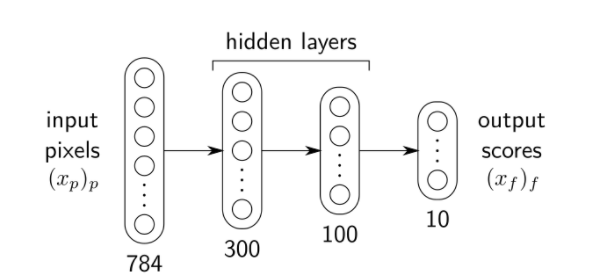

## Load a trained model

In [9]:
nn = modules.Network([
    modules.Linear(PATH('mlp/l1')),modules.ReLU(),
    modules.Linear(PATH('mlp/l2')),modules.ReLU(),
    modules.Linear(PATH('mlp/l3')),
])

In [51]:
modules.Linear(PATH('mlp/l1')).W.shape

(784, 300)

## Define related classes

In [10]:
class Network(modules.Network):
    def relprop(self,R):
        for l in self.layers[::-1]: R = l.relprop(R)
        return R

In [11]:
class ReLU(modules.ReLU):
    def relprop(self,R): return R

In [12]:
class NextLinear(modules.Linear):
    def relprop(self,R):
        V = np.maximum(0,self.W)
        Z = np.dot(self.X,V)+1e-9; S = R/Z
        C = np.dot(S,V.T);         R = self.X*C
        return R

In [13]:
class FirstLinear(modules.Linear):
    def relprop(self,R):
        W,V,U = self.W,np.maximum(0,self.W),np.minimum(0,self.W)
        X,L,H = self.X,self.X*0+utils.lowest,self.X*0+utils.highest

        Z = np.dot(X,W)-np.dot(L,V)-np.dot(H,U)+1e-9; S = R/Z
        R = X*np.dot(S,W.T)-L*np.dot(S,V.T)-H*np.dot(S,U.T)
        return R

## Load MNIST Data

In [14]:
X,T = utils.getMNISTsample(N=12,path='data/mnist',seed=1234)

In [15]:
np.loadtxt(PATH('mlp/l3')+'-W.txt').shape

(100, 10)

In [52]:
X.shape

(12, 784)

In [16]:
utils.visualize(X,utils.graymap,'data.png')

## Sensitivity Analysis

In [17]:
Y = nn.forward(X)
S = nn.gradprop(T)**2

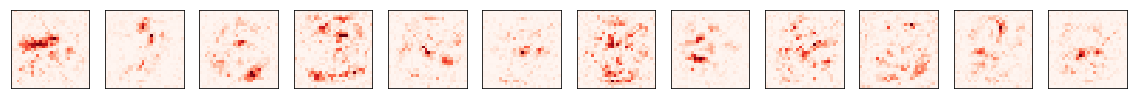

In [18]:
def plot_digits(data):
    total = data.shape[0]
    plt.figure(figsize=(20,5))
    
    for i in range(total):
        plt.subplot(1,12,i+1)
        plt.imshow(data[i,:].reshape((28,28)), cmap="Reds")
        plt.xticks([])
        plt.yticks([])
plot_digits(S)

## Relevance Prop

In [19]:
rel_prop_nn = Network([
    FirstLinear(PATH('mlp/l1')),ReLU(),
    NextLinear(PATH('mlp/l2')),ReLU(),
    NextLinear(PATH('mlp/l3')),ReLU(),
])

In [20]:
Y = rel_prop_nn.forward(X)
D = rel_prop_nn.relprop(Y*T)

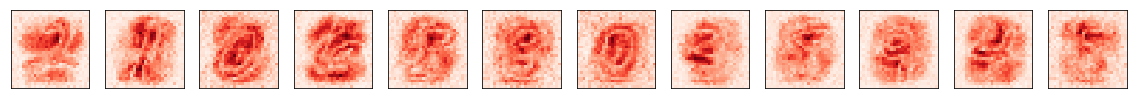

In [21]:
plot_digits(D)

# Relevance Propagation for Convolutional Neural Networks

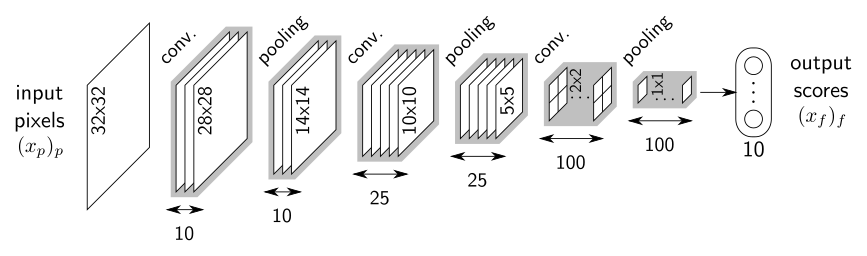

## Define network and related classes

In [38]:
cnn = modules.Network([
    modules.Convolution(PATH('cnn/c1-5x5x1x10')),modules.ReLU(),modules.Pooling(),
    modules.Convolution(PATH('cnn/c2-5x5x10x25')),modules.ReLU(),modules.Pooling(),
    modules.Convolution(PATH('cnn/c3-4x4x25x100')),modules.ReLU(),modules.Pooling(),
    modules.Convolution(PATH('cnn/c4-1x1x100x10')),
])
# filter_width, filter_height, input_channel, no.filter

In [39]:
class NextConvolution(modules.Convolution):
    def relprop(self,R):
        pself = copy.deepcopy(self); pself.B *= 0; pself.W = np.maximum(0,pself.W)

        Z = pself.forward(self.X)+1e-9; S = R/Z
        C = pself.gradprop(S);          R = self.X*C
        return R

In [40]:
class FirstConvolution(modules.Convolution):
    def relprop(self,R):
        iself = copy.deepcopy(self); iself.B *= 0
        nself = copy.deepcopy(self); nself.B *= 0; nself.W = np.minimum(0,nself.W)
        pself = copy.deepcopy(self); pself.B *= 0; pself.W = np.maximum(0,pself.W)
        X,L,H = self.X,self.X*0+utils.lowest,self.X*0+utils.highest

        Z = iself.forward(X)-pself.forward(L)-nself.forward(H)+1e-9; S = R/Z

        R = X*iself.gradprop(S)-L*pself.gradprop(S)-H*nself.gradprop(S)
            print(R.shape)
#         R = X*np.dot(S,W.T)-L*np.dot(S,V.T)-H*np.dot(S,U.T)

        return R


In [41]:
class Pooling(modules.Pooling):
    def relprop(self,R):
        Z = (self.forward(self.X)+1e-9); S = R / Z
        C = self.gradprop(S);            R = self.X*C
        return R

## Application to MNIST data

In [42]:
padding = ((0,0),(2,2),(2,2),(0,0))

In [43]:
X_cnn = np.pad(X.reshape([12,28,28,1]),padding,'constant',constant_values=(utils.lowest,))
T_cnn = T.reshape([12,1,1,10])

In [44]:
Y_cnn = cnn.forward(X_cnn)
S_cnn = cnn.gradprop(T_cnn)**2

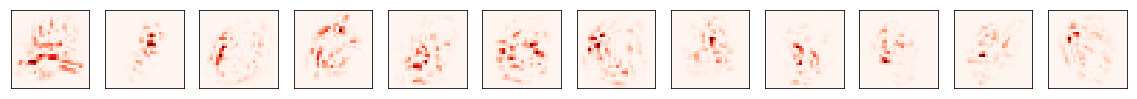

In [45]:
plot_digits(S_cnn[:,2:-2,2:-2])

In [46]:
rel_cnn = Network([
    FirstConvolution(PATH('cnn/c1-5x5x1x10')),ReLU(),Pooling(),
    NextConvolution(PATH('cnn/c2-5x5x10x25')),ReLU(),Pooling(),
    NextConvolution(PATH('cnn/c3-4x4x25x100')),ReLU(),Pooling(),
    NextConvolution(PATH('cnn/c4-1x1x100x10')),
])

(12, 32, 32, 1)


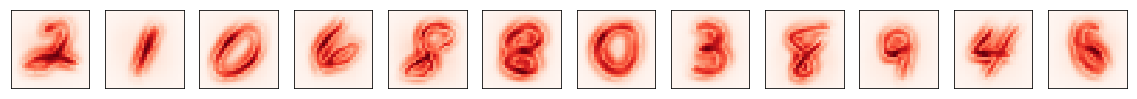

In [47]:
Y_rel = rel_cnn.forward(X_cnn)
D_rel = rel_cnn.relprop(Y_rel*T_cnn)
plot_digits(D_rel[:,2:-2,2:-2])

## Increase the Focus of Explanations with the LRP-αβ rule

In [102]:
class NextConvolutionAlphaBeta(modules.Convolution,object):

    def __init__(self,name,alpha):
        super(self.__class__, self).__init__(name)
        self.alpha = alpha
        self.beta  = alpha-1
        
    def relprop(self,R):
        pself = copy.deepcopy(self); pself.B *= 0; pself.W = numpy.maximum( 1e-9,pself.W)
        nself = copy.deepcopy(self); nself.B *= 0; nself.W = numpy.minimum(-1e-9,nself.W)

        X = self.X+1e-9
        ZA = pself.forward(X); SA =  self.alpha*R/ZA
        ZB = nself.forward(X); SB = -self.beta *R/ZB
        R = X*(pself.gradprop(SA)+nself.gradprop(SB))
        return R

In [119]:
alpha = 1.5

In [120]:
ab_rel_cnn = Network([
    FirstConvolution(PATH('cnn/c1-5x5x1x10')),ReLU(),Pooling(),
    NextConvolutionAlphaBeta(PATH('cnn/c2-5x5x10x25'),alpha),ReLU(),Pooling(),
    NextConvolutionAlphaBeta(PATH('cnn/c3-4x4x25x100'),alpha),ReLU(),Pooling(),
    NextConvolutionAlphaBeta(PATH('cnn/c4-1x1x100x10'),alpha),ReLU(),
])

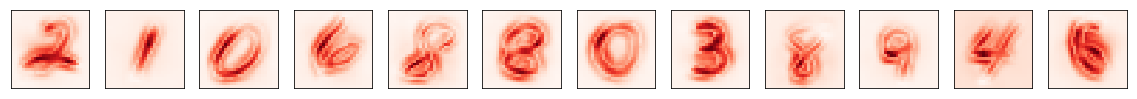

In [121]:
Y_ab_rel = ab_rel_cnn.forward(X_cnn)
D_ab_rel = ab_rel_cnn.relprop(Y_ab_rel*T_cnn)
plot_digits(D_ab_rel[:,2:-2,2:-2])